In [1]:
from skimage.morphology import skeletonize, medial_axis
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
# imports
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import h5py
from utilitary import *


In [3]:
hf = h5py.File("dataset2.h5", "r")

In [4]:
keys = hf.keys()
# Some keys are empty. Remove them
use_key = remove_empty_key(keys, hf)
x,y,z = hf.get('0')['frame'][0].shape      
nb_entries = len(use_key) 
list_keys = list(use_key)

In [5]:
# Split train-validation set
# 80% train - 20% validation
ratio = 0.8
keys_random = np.random.permutation(nb_entries)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]

In [6]:
# Calculate the max intensity projection according to axis = 2 (z-axis)
rMIP, gMIP = MIP_GR(hf, list_keys, axis = 2)
# Save the MIP to avoid loosing 2mn30 each time
np.save('red.npy', rMIP)
np.save('green.npy', gMIP)

In [7]:
rMIP = np.load('red.npy')
gMIP = np.load('green.npy')

In [17]:
# Find the mask of every frame of the red channel
masks = np.empty((len(use_key), x, y, z), dtype=np.int8)

for i, key in enumerate(use_key):
    a = hf.get(key)['frame'][0]
    a = cv2.medianBlur(a, 5)
    masks[i] = np.where(a > 130, 1, 0)


In [21]:
# Apply the mask on the green channel
g_masked = np.zeros((len(use_key), x, y, z), dtype=np.int16)

for i, key in enumerate(use_key):
    a = hf.get(key)['frame'][1]
    a = cv2.medianBlur(a, 5)
    g_masked[i] = np.multiply(a, masks[i])

In [22]:
def np_MIP(data, list_keys, axis):
    """ Mean intensity projection (MIP) to axis
        Arguments :
            data : h5 data
            list_keys : list of keys contained in data
            axis : axis for the projection
        Returns :
            MIP : np.array of dimensions (nb_vol, x, y, 3) of
                  the MIP.
                  The last dimension contains the RGB values
            MIP_avg : np.array of dimensions (nb_vol, x, y) of
                      the MIP.
                      The last dimension contains the mean RGB values
    """
    
    nb_vol, x,y,z = data.shape

    
    if axis == 2:
        MIP = np.empty((nb_vol, x, y))
    elif axis == 1:
        MIP = np.empty((nb_vol, x, z))
    else:
        MIP = np.empty((nb_vol, y, z))

    for i,key in enumerate(list_keys):
        MIP[i] = np.max(data[i], axis = axis)

    return MIP

In [23]:
# MIP of the green maschannel 
g_mip = np_MIP(g_masked, list_keys, axis=2)


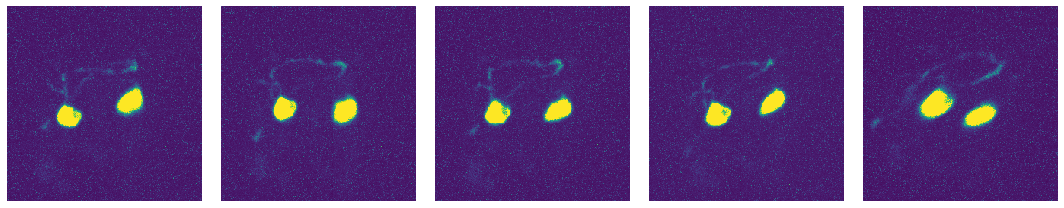

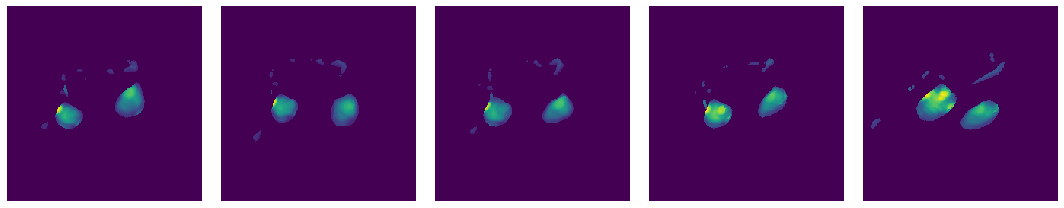

In [24]:
red, green, contours = crop_ctr_mass_GR(rMIP, g_mip, size=128)
a = [red[i] for i in range(5)]
c = [green[i] for i in range(5)]
ne.plot.slices(a, do_colorbars=True);
ne.plot.slices(c, do_colorbars=True);

In [25]:
# Split train-validation set
# 80% train - 20% validation
ratio = 0.8
keys_random = np.random.permutation(nb_entries)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]

# Train on the contours
Contours_train = red[keys_train]
# Test on the "original" MIP_avg
MIP_avg_test = red[keys_test]

Instructions for updating:
Use fn_output_signature instead
Epoch 1/4
110/110 [==============================] - 120s 1s/step - loss: 0.0228 - vxm_dense_transformer_loss: 0.0228 - vxm_dense_flow_loss: 0.0089
Epoch 2/4
110/110 [==============================] - 123s 1s/step - loss: 0.0172 - vxm_dense_transformer_loss: 0.0171 - vxm_dense_flow_loss: 0.1185
Epoch 3/4
110/110 [==============================] - 120s 1s/step - loss: 0.0159 - vxm_dense_transformer_loss: 0.0157 - vxm_dense_flow_loss: 0.1722
Epoch 4/4
110/110 [==============================] - 118s 1s/step - loss: 0.0157 - vxm_dense_transformer_loss: 0.0155 - vxm_dense_flow_loss: 0.1863


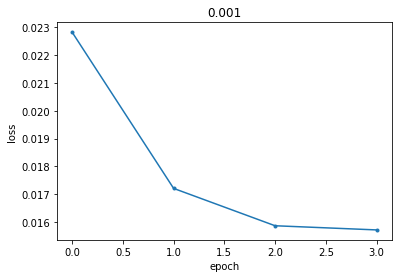

Epoch 1/4
110/110 [==============================] - 114s 1s/step - loss: 0.0197 - vxm_dense_transformer_loss: 0.0174 - vxm_dense_flow_loss: 0.0223
Epoch 2/4
110/110 [==============================] - 120s 1s/step - loss: 0.0185 - vxm_dense_transformer_loss: 0.0172 - vxm_dense_flow_loss: 0.0127
Epoch 3/4
110/110 [==============================] - 121s 1s/step - loss: 0.0180 - vxm_dense_transformer_loss: 0.0167 - vxm_dense_flow_loss: 0.0124
Epoch 4/4
110/110 [==============================] - 118s 1s/step - loss: 0.0187 - vxm_dense_transformer_loss: 0.0175 - vxm_dense_flow_loss: 0.0125


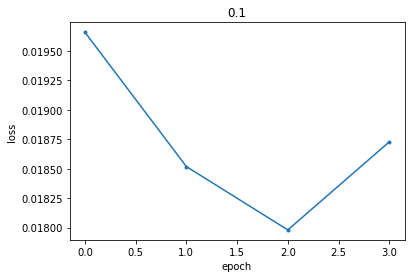

In [17]:
# UNET architecture

vol_shape = (x, y) # 32 slices
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-3,-1,2)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
#     vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=2)
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = vxm_data_generator(Contours_train, batch_size = 1)
    hist = vxm_model.fit(train_generator, epochs=4, steps_per_epoch= 110, verbose=1);
    # Visualize the losses
    plot_history(hist, save_name = str(lambda_))
    title = "weights" + str(lambda_) + ".keras"
    # If it looks ok => save the weights
    vxm_model.save_weights(title)

In [26]:
# Load the best weights found
# title = "weights" + str(0.001) + ".keras"
title = "weights_rchan0.01.keras"
vxm_model.load_weights(title)

# Validation set generator
val_generator = vxm_data_generator(MIP_avg_test, batch_size = 15)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

In [7]:
# Plot some MIP_avg moving & moved, to see the results
moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]
c = [fixed[i, ...] for i in range(5)]

titles1 = ['moving' + str(i) for i in range(5)]
titles3 = ['fixed' + str(i) for i in range(5)]
titles2 = ['moved' + str(i) for i in range(5)]
# Moving
ne.plot.slices(b, titles=titles1, do_colorbars=True);
# fixed
ne.plot.slices(c, titles=titles3, do_colorbars=True);
# Moved
ne.plot.slices(a, titles=titles2, do_colorbars=True);

NameError: name 'val_input' is not defined

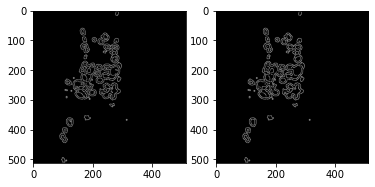

In [87]:
# Another segmentation method : Canny
fig, (ax1, ax2) = plt.subplots(ncols=2)
im_ok = im.astype(np.uint8)
edges = cv2.Canny(im_ok,0.5,1)
ax1.imshow(edges,cmap = 'gray')

im_ok = im.astype(np.uint8)
blur = cv2.GaussianBlur(im_ok,(5,5),0)
edges = cv2.Canny(blur,0.5,1)
ax2.imshow(edges,cmap = 'gray')

In [1]:
vol_shape = (500, 500) # 32 slices
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-3,-1,2)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
#     vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=2)
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = vxm_data_generator(Contours_train, batch_size = 1)
    hist = vxm_model.fit(train_generator, epochs=4, steps_per_epoch= 110, verbose=1);
    # Visualize the losses
    plot_history(hist, save_name = str(lambda_))


NameError: name 'vxm' is not defined